# **Project 9: Advanced Out-of-Distribution Detection for Multi-Class Classification**   

## Project Overview

The goal of this project is to address the challenge of out-of-distribution (OOD) detection in deep learning, particularly in the context of multi-class image classification. In real-world scenarios, models often encounter data that differ significantly from their training distribution, which can lead to unreliable or unsafe predictions. Therefore, detecting and properly handling OOD inputs is crucial for building robust and trustworthy AI systems.

The first step involves training a deep neural network classifier on the **Food-101** dataset, which serves as the in-distribution (ID) data. This dataset includes high-dimensional images with complex visual features, making it a suitable benchmark for evaluating model performance in realistic settings.

Once the classifier is trained, we will implement one or more OOD detection methods. The **SVHN (Street View House Numbers)** dataset will be used as the primary OOD source, providing visually distinct samples that test the model’s ability to separate known from unknown inputs. Techniques such as energy-based or gradient-based scoring can be applied to detect OOD samples effectively.

Additionally, the project can be extended by incorporating other OOD datasets to further assess the generalizability of the detection framework. The final objective is to evaluate the model’s capability to distinguish between in-distribution and out-of-distribution examples using appropriate metrics, such as AUROC, AUPR, and FPR@95.

# Imports

In this section, we import all the necessary libraries required for building, training, and evaluating the model, as well as for implementing OOD detection. These include:

- **Torch / torchvision** for model definition, training, and dataset loading
- **NumPy / Pandas** for data manipulation
- **Matplotlib** for visualization
- **Scikit-learn** for computing evaluation metrics
- **Custom utility functions** (if any) for training loops, loss functions, and OOD scoring

In [1]:
# Installazione di librerie mancanti
!pip install tqdm

# Core Python
import os
import time
import copy
import random
from collections import defaultdict
from itertools import cycle, islice


import numpy as np
from scipy.io import loadmat
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# PyTorch - base
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset, random_split
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau, StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
)

# PyTorch - torchvision
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder, VisionDataset

# Progress bar
from tqdm.notebook import tqdm

# Scikit-learn
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix, average_precision_score
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# Hardware Check

Before starting the training process, we check whether a GPU is available for computation. If CUDA is available, the code will use the GPU to accelerate training. Otherwise, it will fall back to the CPU. Basic system information, such as GPU model and memory or CPU details, is also displayed to help monitor the hardware configuration.

In [2]:
def hardware_check():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")
        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")
    return device

device = hardware_check()
print(f"\nUsing {device} for computation")

GPU is available!
  -> GPU - Tesla P100-PCIE-16GB
  -> Total Memory: 15.89 GB

Using cuda for computation


# Globals

We use a batch size of 64 throughout, and two separate initial learning rates:
* LR_ID_INIT for the base Food-101 fine-tuning phase
* LR_OE_INIT for the Outlier Exposure stage

A small weight decay (WEIGHT_DECAY=1e-4) helps regularize training in both phases. Each phase runs for 15 epochs (EPOCHS_ID / EPOCHS_OE), with early stopping after 6 epochs of no improvement during OE (PATIENCE=6).

For Outlier Exposure specifically, we introduce:
* energy margins M_IN / M_OUT to define hinge losses on in- and out-of-distribution energies
* a maximum OE weight LAMBDA_MAX and balance term ALPHA_ID
* a warm-up (3 epochs) and linear ramp (2 epochs) schedule to gradually apply the OE penalty
* a softmax temperature TEMPERATURE for energy scoring

All images are normalized with the standard ImageNet channel means and standard deviations (MEAN, STD) for consistency with the pretrained backbone.

In [3]:
BATCH_SIZE      = 64
LR_ID_INIT      = 2e-4      # training
LR_OE_INIT      = 3e-4      # fine‑tuning
WEIGHT_DECAY    = 1e-4
EPOCHS_ID       = 15
EPOCHS_OE       = 15 

# OE‑specifici
M_IN, M_OUT     = -6.0, -0.5
LAMBDA_MAX      = 0.06
ALPHA_ID        = 0.05
WARMUP_EP       = 3
RAMP_EP         = 2
PATIENCE        = 7
TEMPERATURE     = 1.0

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

# Data and Trasformation

Below we define the image‐level preprocessing pipelines for our in-distribution (ID) Food-101 data and out-of-distribution (OOD) SVHN data. During training we apply a rich suite of random augmentations—resizing, random crops, flips, rotations, color jitter, affine and perspective warps, plus random erasing—to help the model learn robust, invariant features. At test time (both for ID and OOD) we use a single deterministic resize, center crop and normalize flow so that evaluation is stable and reproducible.

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

ood_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD)
])

**Food-101**

We load Food-101 via ImageFolder, pointing it at the top-level image directories, and then apply the official train.txt / test.txt metadata files to split exactly as the dataset creators intended. From the resulting training set, we carve off a stratified 10% sample, meaning we randomly select examples in proportion to each of the 101 classes, to serve as our validation set. This simple hold-out preserves the original class balance, so we can tune hyperparameters and monitor for overfitting without disturbing the integrity of the published train/test split.

In [5]:
val_split = 0.1  # 10% per validation

# Percorsi dataset e file di split
dataset_root = "/kaggle/input/food101/food-101"
images_root = os.path.join(dataset_root, "images")
train_txt = os.path.join(dataset_root, "meta", "train.txt")
test_txt = os.path.join(dataset_root, "meta", "test.txt")

print("📂 Dataset root:", dataset_root)
print("📄 File train.txt esiste:", os.path.exists(train_txt))
print("📄 File test.txt esiste:", os.path.exists(test_txt))

# FULL DATASET
full_dataset_train = ImageFolder(root=images_root, transform=train_transform)
full_dataset_eval  = ImageFolder(root=images_root, transform=test_transform)

print(f"✅ Dataset completo caricato: {len(full_dataset_train)} immagini totali")
print(f"   📦 Numero classi: {len(full_dataset_train.classes)}")

# INDICI
def load_indices(txt_file, dataset):
    with open(txt_file, "r") as f:
        lines = f.read().splitlines()
    idxs = []
    for rel_path in lines:
        for i, (img_path, _) in enumerate(dataset.samples):
            if rel_path in img_path:
                idxs.append(i)
                break
    return idxs

train_indices = load_indices(train_txt, full_dataset_train)
test_indices = load_indices(test_txt, full_dataset_train)
print(f"✅ Indici caricati — Train: {len(train_indices)}, Test: {len(test_indices)}")

# STRATIFIED SPLIT
train_labels = [full_dataset_train.samples[i][1] for i in train_indices]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)
train_idx, val_idx = next(splitter.split(train_indices, train_labels))

# DATASET CON TRASFORMAZIONI CORRETTE
train_id = Subset(full_dataset_train, [train_indices[i] for i in train_idx])
val_id   = Subset(full_dataset_eval,  [train_indices[i] for i in val_idx])
test_id  = Subset(full_dataset_eval,  test_indices)

print(f"🎉 Sottodataset creati — Train: {len(train_id)}, Validation: {len(val_id)}, Test: {len(test_id)}")

📂 Dataset root: /kaggle/input/food101/food-101
📄 File train.txt esiste: True
📄 File test.txt esiste: True
✅ Dataset completo caricato: 101000 immagini totali
   📦 Numero classi: 101
✅ Indici caricati — Train: 75750, Test: 25250
🎉 Sottodataset creati — Train: 68175, Validation: 7575, Test: 25250


**SVHN**

For Outlier Exposure, we can’t simply use ImageFolder because SVHN is stored in MATLAB .mat files.  So we wrap those with a tiny VisionDataset subclass that (a) loads the .mat, (b) transposes the arrays into standard H×W×C form, and then (c) returns only images, no labels, so that our OE loss sees “unlabeled” outliers.  From the SVHN training pool we then draw a random 30% sample (via torch.randperm) to use during model fitting, while reserving the full SVHN test set as a clean benchmark for OOD detection after training.

In [6]:
#restituisce solo img (senza label)
class SVHNFromMat(VisionDataset):
    def __init__(self, mat_path, transform=None):
        super().__init__(root="", transform=transform)
        data = loadmat(mat_path)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))  # (N, H, W, C)

        print(f"📥 Caricato: {mat_path}")
        print(f"  → Immagini: {self.images.shape}")

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index])
        if self.transform:
            img = self.transform(img)
        return img  # 🔁 SOLO immagine, nessuna label

    def __len__(self):
        return len(self.images)

# ✅ Inizializzazione dataset
svhn_train_path = "/kaggle/input/svhndataset/train_32x32.mat"
svhn_test_path = "/kaggle/input/svhndataset/test_32x32.mat"

svhn_train = SVHNFromMat(svhn_train_path, transform=ood_transform)
svhn_test = SVHNFromMat(svhn_test_path, transform=ood_transform)

# ✅ Subset per training OOD 
ood_fraction = 0.30
subset_idx   = torch.randperm(len(svhn_train))[: int(ood_fraction * len(svhn_train))]
svhn_subset  = Subset(svhn_train, subset_idx)

print(f"🎯 SVHN subset creato: {len(svhn_subset)} immagini "
      f"({ood_fraction*100:.0f}% di {len(svhn_train)})")

📥 Caricato: /kaggle/input/svhndataset/train_32x32.mat
  → Immagini: (73257, 32, 32, 3)
📥 Caricato: /kaggle/input/svhndataset/test_32x32.mat
  → Immagini: (26032, 32, 32, 3)
🎯 SVHN subset creato: 21977 immagini (30% di 73257)


After loading the datasets, we wrap each split in a PyTorch DataLoader to efficiently iterate over mini-batches during training and evaluation. We shuffle only the training streams and keep validation/test loaders deterministic. We also halve the OOD batch size so that mixing ID+OOD examples still yields a balanced overall batch.

In [7]:
train_id_loader = DataLoader(train_id , batch_size=BATCH_SIZE, shuffle=True ,
                             num_workers=2, pin_memory=True)
val_id_loader   = DataLoader(val_id   , batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=2, pin_memory=True)
svhn_loader     = DataLoader(svhn_subset, batch_size=BATCH_SIZE//2, shuffle=True,
                             num_workers=2, pin_memory=True)
test_loader     = DataLoader(test_id, batch_size=BATCH_SIZE, shuffle=False, 
                             num_workers=4)
ood_loader      = DataLoader(svhn_test, batch_size=BATCH_SIZE, shuffle=False, 
                             num_workers=2)

# Network

As the starting point for our project, we chose ResNet-50 as our model because it offers a great trade-off between accuracy and speed. Its residual blocks let us go deep enough to learn complex visual patterns (textures, shapes, colors) without training instabilities, and starting from ImageNet–pretrained weights means we need fewer epochs and less data to reach strong performance on 101 food categories.

**How `build_resnet50_food101` works**  
1. **Load the backbone**  
   We instantiate the standard ResNet-50 model, optionally loading ImageNet weights to give us rich, general-purpose feature detectors from the very first iteration.  
2. **Swap in a new head**  
   The original 1000-class head is replaced with a small block that first applies dropout (to prevent overfitting) and then a linear layer that outputs exactly 101 logits—one per food category.  
3. **Move to device**  
   If you specify a `device` (e.g. `"cuda"`), the model is sent there automatically so you can start training or inference right away without extra boilerplate.

By wrapping these steps in a single function, we guarantee that both our baseline and Outlier Exposure experiments use the exact same architecture and initialization.  

In [8]:
def build_resnet50_food101(
        num_classes: int = 101,
        pretrained: bool = True,
        dropout_p: float = 0.3,
        device: torch.device | str = None
) -> nn.Module:
    
    # 1) Backbone
    weights = ResNet50_Weights.DEFAULT if pretrained else None
    model = resnet50(weights=weights)

    # 2) Head personalizzato
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(model.fc.in_features, num_classes)
    )

    # 3) Spostamento su device se richiesto
    if device is not None:
        model = model.to(device)

    return model

#  Standard In-Distribution Training

We begin by training a standard ResNet-50 model on Food-101 only, no out-of-distribution data, no auxiliary losses.  Our objectives are:  
1. Teach the network to discriminate among the 101 food categories as effectively as possible.  
2. Produce a “vanilla” classifier that we can later probe on truly out-of-distribution images (SVHN and beyond) to quantify its native OOD rejection behavior.

During each epoch we:

1. **Forward + Backward**  
   For each mini-batch, we compute the network logits and convert them to probabilities via softmax:  
   $$
   p_{i,c} \;=\; \frac{\exp(z_{i,c})}{\sum_{k=1}^{101}\exp(z_{i,k})}\,.
   $$  
   We then apply label smoothing (\$\epsilon=0.1\$) to the true-class probability:  
   $$
   p_{i,y_i}^* \;=\; (1 - \epsilon)\times 1 \;+\; \frac{\epsilon}{101}\,.
   $$  
   The resulting cross-entropy loss is  
   $$
   \mathcal{L}_{\mathrm{CE}}
   \;=\;
   -\frac{1}{B}\sum_{i=1}^{B} \log p_{i,y_i}^*\,.
   $$  
    Calling `loss.backward()` back-propagates the gradient  
    $$\nabla \mathcal{L}_{\mathrm{CE}}$$  
    through the network, and `optimizer.step()` (Adam) updates every parameter accordingly. This pair of operations—forward pass to compute $$\mathcal{L}_{\mathrm{CE}}$$  
    then backward pass to adjust parameters—drives the model to better classify each food category.  
2. **Learning-rate schedule**  
   Every 5 epochs we halve the learning rate. This lets the optimizer make big updates early, then finer adjustments later.

3. **Progress monitoring**  
   A `tqdm` progress bar shows the running loss and top-1 accuracy for each mini-batch.

This run produces our baseline Food-101 classifier. In the next phase we’ll evaluate its OOD detection performance (energy and MSP scores on SVHN) before adding any Outlier Exposure penalties.  

In [9]:
model = build_resnet50_food101()    
model = model.to(device)

criterion  = nn.CrossEntropyLoss(label_smoothing=0.1)  

optimizer  = optim.Adam(model.parameters(),lr=LR_ID_INIT, weight_decay=WEIGHT_DECAY)

# ───────────────────────────────────────────────────────────────
# Training 
# ───────────────────────────────────────────────────────────────
print(f"\n🚀 Learning-rate iniziale: {LR_ID_INIT:.1e}")

for epoch in range(EPOCHS_ID):                   
    # scheduler manuale: dimezza il LR ogni 5 epoche
    if epoch > 0 and epoch % 5 == 0:    
        for g in optimizer.param_groups:
            g["lr"] *= 0.5            
        print(f"\n🔁 LR dimezzato → {optimizer.param_groups[0]['lr']:.1e}")

    print(f"\nEpoch {epoch+1}/{EPOCHS_ID} — samples: {len(train_id_loader.dataset)}")
    model.train()
    running_loss = 0.0
    correct = total = 0

    loop = tqdm(train_id_loader, leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # forward + backward
        outputs = model(images)
        loss    = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()
        total   += labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        loop.set_postfix(
            loss = running_loss / (loop.n + 1),
            acc  = 100.0 * correct / total
        )

    print(f"✅ Epoch {epoch+1} — Train ACC: {100.0 * correct / total:.2f}%")


🚀 Learning-rate iniziale: 2.0e-04

Epoch 1/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 1 — Train ACC: 46.50%

Epoch 2/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 2 — Train ACC: 61.66%

Epoch 3/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 3 — Train ACC: 65.34%

Epoch 4/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 4 — Train ACC: 67.49%

Epoch 5/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 5 — Train ACC: 69.30%

🔁 LR dimezzato → 1.0e-04

Epoch 6/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 6 — Train ACC: 74.29%

Epoch 7/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 7 — Train ACC: 76.18%

Epoch 8/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 8 — Train ACC: 76.94%

Epoch 9/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 9 — Train ACC: 78.02%

Epoch 10/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 10 — Train ACC: 78.32%

🔁 LR dimezzato → 5.0e-05

Epoch 11/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 11 — Train ACC: 80.96%

Epoch 12/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 12 — Train ACC: 82.13%

Epoch 13/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 13 — Train ACC: 82.81%

Epoch 14/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 14 — Train ACC: 83.23%

Epoch 15/15 — samples: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

✅ Epoch 15 — Train ACC: 83.56%


# Evaluation

In the evaluation phase, we first measure the classifier’s accuracy on in-distribution (Food-101) test images to quantify standard recognition performance. Next, we assess the model’s ability to detect out-of-distribution (OOD) samples by feeding it SVHN images and computing energy and max-softmax scores. From these scores we derive:
	
* AUROC to capture overall separability between ID and OOD.
* FPR@95 TPR to report the false positive rate when correctly identifying 95 % of in-distribution samples.
* AUPR-In to summarize precision-recall trade-offs treating ID as the positive class.


Plotting ROC and PR curves alongside score histograms completes the evaluation, giving both quantitative metrics and visual insight into how well the model distinguishes familiar from unfamiliar images.

Testing:   0%|          | 0/395 [00:00<?, ?it/s]


Final Test Accuracy: 86.78%


MSP:   0%|          | 0/395 [00:00<?, ?it/s]

MSP:   0%|          | 0/407 [00:00<?, ?it/s]


📊  METRICHE OOD  (ID = Food-101,  OOD = SVHN)
• AUROC  (Energy)      : 0.8838
• AUROC  (Soft-max)    : 0.9998
• FPR@95TPR (Energy)   : 0.03%
• FPR@95TPR (Soft-max) : 0.13%
• AUPR-In (Energy)     : 0.9363
• AUPR-In (Soft-max)   : 0.9997


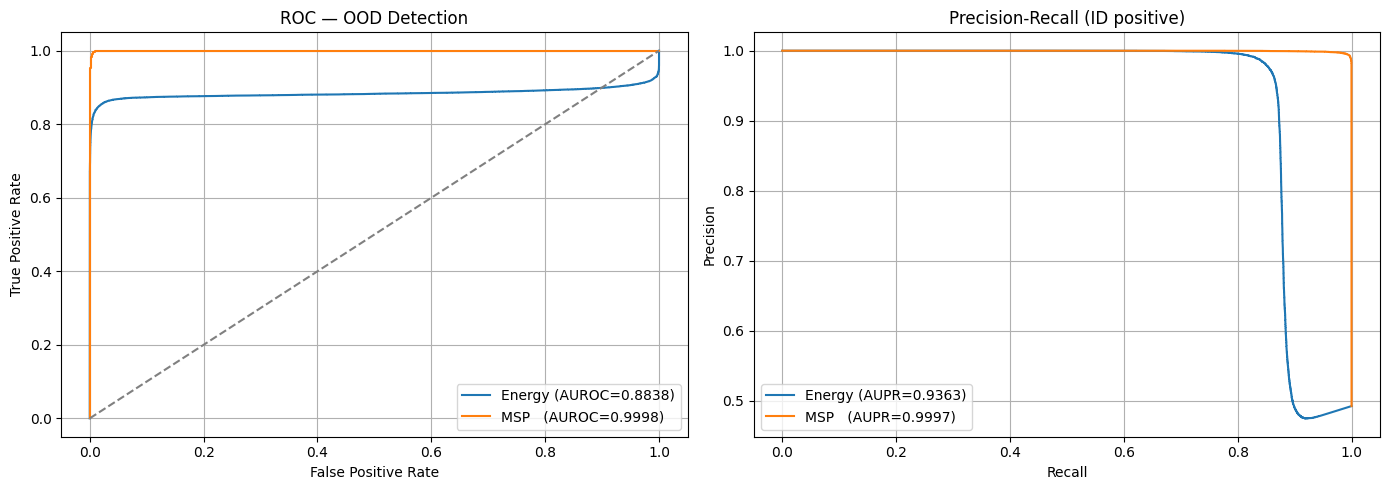

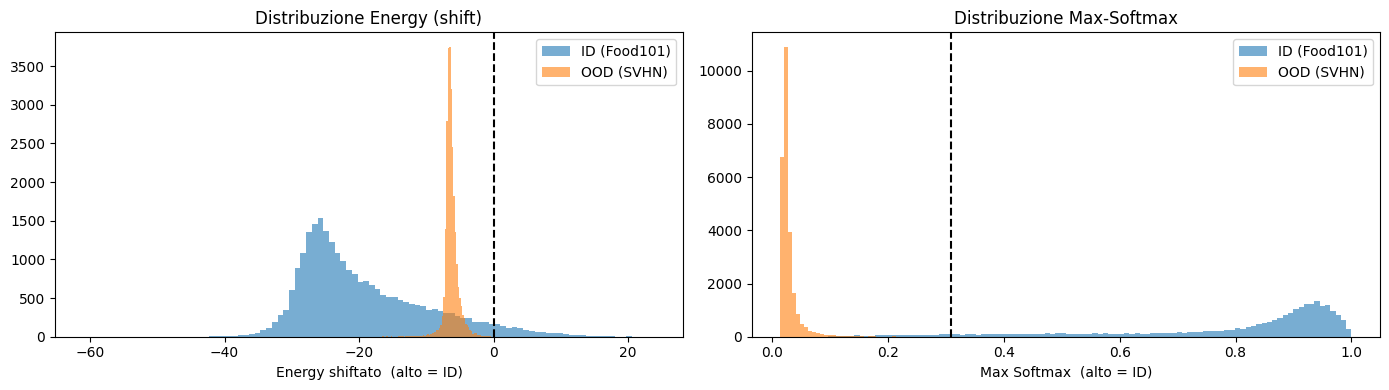

In [10]:
model.eval()
T = 0.2                          # temperatura trovata con grid-search

correct = 0
total = 0
with torch.no_grad():
    test_loop = tqdm(test_loader, total=len(test_loader), desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")

# ------------------------------------------------
# 1.  Utility
# ------------------------------------------------
def fpr_at_given_tpr(fpr, tpr, target_tpr=0.95):
    """FPR corrispondente a target_tpr (interpolazione)."""
    if tpr[-1] < target_tpr:      # la ROC non raggiunge il target
        return 1.0
    return float(np.interp(target_tpr, tpr, fpr))

def _images_from(batch):
    """Estrae solo le immagini indipendentemente dalla forma del batch."""
    return batch[0] if isinstance(batch, (list, tuple)) else batch

# ------------------------------------------------
# 2.  Funzioni di scoring (gestiscono entrambi i casi)
# ------------------------------------------------
@torch.no_grad()
def energy_scores(loader, T):
    out = []
    for batch in loader:
        x = _images_from(batch).to(device, non_blocking=True)
        out.append((-torch.logsumexp(model(x) / T, 1)).cpu())
    return torch.cat(out).numpy()        # shape (N,)

@torch.no_grad()
def msp_scores(loader):
    out = []
    for batch in tqdm(loader, desc="MSP", leave=False):
        x = _images_from(batch).to(device, non_blocking=True)
        out.append(torch.softmax(model(x), dim=1).max(1).values.cpu())
    return torch.cat(out).numpy()

# ------------------------------------------------
# 3.  Calcolo score   (ID = Food-101  |  OOD = SVHN)
# ------------------------------------------------
id_energy  = energy_scores(test_loader, T)
ood_energy = energy_scores(ood_loader,  T)

id_msp  = msp_scores(test_loader)
ood_msp = msp_scores(ood_loader)

# ------------------------------------------------
# 4.  m-shift sull’Energy  (95-percentile ID)
# ------------------------------------------------
m            = np.percentile(id_energy, 95)
id_energy_s  = id_energy  - m
ood_energy_s = ood_energy - m
energy_cat   = -np.concatenate([id_energy_s, ood_energy_s])   # alto = ID
labels       = np.concatenate([np.ones_like(id_energy_s),
                               np.zeros_like(ood_energy_s)])

# ------------------------------------------------
# 5.  Metriche
# ------------------------------------------------
auroc_energy = roc_auc_score(labels, energy_cat)
auroc_msp    = roc_auc_score(labels, np.concatenate([id_msp, ood_msp]))

fpr_e, tpr_e, _ = roc_curve(labels, energy_cat)
fpr_s, tpr_s, _ = roc_curve(labels, np.concatenate([id_msp, ood_msp]))

# soglie per FPR@95TPR
tau_energy   = 0.0                     # perché abbiamo shiftato
tau_msp      = np.percentile(id_msp, 5)

fpr95_energy = (ood_energy_s >  tau_energy).mean()
fpr95_msp    = (ood_msp      >  tau_msp   ).mean()

pr_e, rc_e, _ = precision_recall_curve(labels, energy_cat)
pr_s, rc_s, _ = precision_recall_curve(labels,
                                       np.concatenate([id_msp, ood_msp]))
aupr_e = average_precision_score(labels, energy_cat)
aupr_m = average_precision_score(labels, np.concatenate([id_msp, ood_msp]))

# ------------------------------------------------
# 6.  Stampa risultati
# ------------------------------------------------
print("\n📊  METRICHE OOD  (ID = Food-101,  OOD = SVHN)")
print(f"• AUROC  (Energy)      : {auroc_energy:.4f}")
print(f"• AUROC  (Soft-max)    : {auroc_msp:.4f}")
print(f"• FPR@95TPR (Energy)   : {fpr95_energy*100:.2f}%")
print(f"• FPR@95TPR (Soft-max) : {fpr95_msp*100:.2f}%")
print(f"• AUPR-In (Energy)     : {aupr_e:.4f}")
print(f"• AUPR-In (Soft-max)   : {aupr_m:.4f}")

# ------------------------------------------------
# 7.  Curve ROC & PR  +  Istogrammi
# ------------------------------------------------
plt.figure(figsize=(14, 5))
# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_e, tpr_e, label=f"Energy (AUROC={auroc_energy:.4f})")
plt.plot(fpr_s, tpr_s, label=f"MSP   (AUROC={auroc_msp:.4f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — OOD Detection"); plt.legend(); plt.grid(True)

# PR
plt.subplot(1, 2, 2)
plt.plot(rc_e, pr_e, label=f"Energy (AUPR={aupr_e:.4f})")
plt.plot(rc_s, pr_s, label=f"MSP   (AUPR={aupr_m:.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall (ID positive)"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Istogrammi
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Energy
axes[0].hist(id_energy_s,  bins=100, alpha=0.6, label="ID (Food101)")
axes[0].hist(ood_energy_s, bins=100, alpha=0.6, label="OOD (SVHN)")
axes[0].axvline(0, color="k", ls="--")
axes[0].set_title("Distribuzione Energy (shift)")
axes[0].set_xlabel("Energy shiftato  (alto = ID)")
axes[0].legend()

# MSP
axes[1].hist(id_msp,  bins=100, alpha=0.6, label="ID (Food101)")
axes[1].hist(ood_msp, bins=100, alpha=0.6, label="OOD (SVHN)")
axes[1].axvline(tau_msp, color="k", ls="--")
axes[1].set_title("Distribuzione Max-Softmax")
axes[1].set_xlabel("Max Softmax  (alto = ID)")
axes[1].legend()

plt.tight_layout(); plt.show()

# Outlier Exposure: Training ID + OOD 
In this phase, we augment the standard Food-101 fine-tuning with SVHN images and an auxiliary energy-based penalty to push OOD samples away from the in-distribution manifold.  The network still learns the 101 food classes, but now also learns to assign higher “energy” to outliers.

During each epoch:

1. **Outlier Exposure Loss**

    We process mixed mini-batches of ID and OOD images.  For ImageNet-pretrained ResNet-50 with a 101-way head, let
    $$
    E(\mathbf{z}) = -T,\log\sum_c\exp\bigl(z_c/T\bigr)
    $$
    be the energy of logits $\mathbf{z}$.  We impose two hinge-style penalties:
    $$
    \mathcal{L}_{\text{ID}}  = \bigl[\max(E_{\text{ID}} - m_{\text{in}},0)\bigr]^2,\quad
    \mathcal{L}_{\text{OOD}} = \bigl[\max(m_{\text{out}} - E_{\text{OOD}},0)\bigr]^2,
    $$
    and combine them into
    $$
    \mathcal{L}_{\text{OE}} = \lambda*\bigl(\mathcal{L}_{\text{OOD}} + \alpha*\mathcal{L}_{\text{ID}}\bigr).
    $$
    The full training objective is
    $$
    \mathcal{L} = \mathcal{L}_{\text{CE}} + \mathcal{L}_{\text{OE}}.
    $$
    After computing the combined loss, we perform back-propagation of its gradient through the network and then update every model parameter via the optimizer’s update rule.
    	
2. **Warm-up & Ramp for OE Strength**


   We gradually increase $\lambda$ over the first few epochs (warm-up+ramp), then hold it constant at its maximum value.  This avoids overwhelming the classifier before it has learned good food-class features.
	
4. **Label-smoothing Schedule**


   After the OE ramp completes, we decay the label-smoothing factor by 0.05 each epoch to sharpen the ID classification head over time.
	
6.	**Cosine-Restarts Scheduler**


  We use CosineAnnealingWarmRestarts to briefly boost the learning rate at regular intervals (T₀=5, Tₘₚₗ=2), enabling fresh exploration without extending total epochs.
	
8.	**Monitoring & Early-Stop**


  A tqdm bar tracks batch-level CE and OE losses plus training accuracy.  Validation loss triggers best-model snapshots, and training stops automatically if no improvement occurs for PATIENCE epochs.

10.	**Batch-Norm re-calibration**

   Once we’ve picked the best model, we feed all Food-101 training images through it one last time (still in training mode but without changing any weights). This lets each BatchNorm layer recompute its running averages so they match the true data—making the model’s behavior more reliable when we finally test it.

This procedure teaches the model not only to recognise food categories, but also to push SVHN samples into a high-energy “outlier” regime, laying the groundwork for robust OOD detection.

In [11]:
model = build_resnet50_food101()    
model = model.to(device)

optimizer  = optim.Adam(model.parameters(), lr=LR_OE_INIT,weight_decay=WEIGHT_DECAY)

scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=5, T_mult=2, eta_min=1e-6)

label_smooth = 0.1                     
criterion_id = nn.CrossEntropyLoss(label_smoothing=label_smooth)
criterion_val = nn.CrossEntropyLoss()


def energy(logits, T=TEMPERATURE):
    return -T * torch.logsumexp(logits / T, dim=1)


# ───────────────────────────────────────────────────────────────
# Training loop
# ───────────────────────────────────────────────────────────────
best_val_loss = float("inf")
best_wts      = copy.deepcopy(model.state_dict())
no_improve    = 0

for epoch in range(EPOCHS_OE):

    # ───── λ (warm-up + ramp) ─────
    if   epoch < WARMUP_EP:
        lam = 0.0
    elif epoch < WARMUP_EP + RAMP_EP:
        lam = LAMBDA_MAX * (epoch - WARMUP_EP + 1) / RAMP_EP
    else:
        lam = LAMBDA_MAX

    # ───── label-smoothing progressivo ─────
    if epoch >= WARMUP_EP + RAMP_EP and label_smooth > 0:
        label_smooth = max(0.0, label_smooth - 0.05)
        criterion_id.label_smoothing = label_smooth

    print(f"\nEpoch {epoch+1}/{EPOCHS_OE}  |  λ={lam:.3f}  |  "
          f"LR={optimizer.param_groups[0]['lr']:.2e}  |  LS={label_smooth:.2f}")

    # ───────── Train ─────────
    model.train()
    ood_iter = iter(svhn_loader)
    run_gap = correct = total = 0

    train_loop = tqdm(
        train_id_loader,
        total=len(train_id_loader),
        desc=f"Train {epoch+1}",
        leave=False
    )

    for i, (x_id, y_id) in enumerate(train_loop, 1):
        try:
            x_ood = next(ood_iter)
        except StopIteration:
            ood_iter = iter(svhn_loader)
            x_ood    = next(ood_iter)

        x_id, y_id, x_ood = x_id.to(device), y_id.to(device), x_ood.to(device)

        # ---- forward + losses ----
        logits_id  = model(x_id)
        logits_ood = model(x_ood)
        loss_ce    = criterion_id(logits_id, y_id)

        e_id    = energy(logits_id)
        e_ood   = energy(logits_ood)
        gap     = (e_ood.mean() - e_id.mean()).item()
        loss_id  = torch.clamp(e_id  - M_IN , min=0).pow(2).mean()
        loss_ood = torch.clamp(M_OUT - e_ood, min=0).pow(2).mean()
        loss_oe  = lam * (loss_ood + ALPHA_ID * loss_id)
        loss     = loss_ce + loss_oe

        # ---- backward ----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ---- stats ----
        run_gap += gap
        correct += (logits_id.argmax(1) == y_id).sum().item()
        total   += y_id.size(0)

        if (i+1) % 100 == 0 or (i+1) == len(train_id_loader):
            print(f"batch {i+1:4d} | gap={gap:4.2f} | "f"CE={loss_ce.item():.3f} | OE={loss_oe.item():.3f}")


    train_acc = 100 * correct / total
    print(f"✅ Train Acc {train_acc:.2f}% — mean gap {run_gap/len(train_id_loader):.2f}")

    # ───────── Validation ─────────
    model.eval()
    val_loss = val_correct = val_total = 0

    val_loop = tqdm(
        val_id_loader,
        total=len(val_id_loader),
        desc=f"Val   {epoch+1}",
        leave=False
    )

    with torch.no_grad():
        for x, y in val_loop:
            out = model(x.to(device))
            l = criterion_val(out, y.to(device)).item()
            val_loss    += l
            val_correct += (out.argmax(1) == y.to(device)).sum().item()
            val_total   += y.size(0)
            val_loop.set_postfix({"val_loss": f"{val_loss/(val_loop.n+1):.4f}", 
                                  "val_acc": f"{100*val_correct/val_total:5.2f}%"})

    val_loss /= len(val_id_loader)
    val_acc   = 100 * val_correct / val_total
    print(f"🔍 Val Loss {val_loss:.4f} — Acc {val_acc:.2f}%")

    # ---- early-stop ----
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_wts      = copy.deepcopy(model.state_dict())
        torch.save(best_wts, "best_model_weights.pth")
        no_improve = 0
        print("💾 best model saved.")
    else:
        no_improve += 1
        print(f"⏳ no improvement ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print("⏹ Early stop triggered.")
            break

    # ---- scheduler ----
    scheduler.step()

# ───── Re-calibrazione BN ─────
model.load_state_dict(best_wts)
model.train()
with torch.no_grad():
    for x, _ in DataLoader(train_id, batch_size=256, shuffle=False):
        _ = model(x.to(device))
model.eval()
print("✅ Best weights loaded & BN re-calibrated.")


Epoch 1/15  |  λ=0.000  |  LR=3.00e-04  |  LS=0.10


Train 1:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=0.08 | CE=3.422 | OE=0.000
batch  200 | gap=0.40 | CE=3.079 | OE=0.000
batch  300 | gap=0.41 | CE=2.912 | OE=0.000
batch  400 | gap=0.53 | CE=2.277 | OE=0.000
batch  500 | gap=0.55 | CE=2.722 | OE=0.000
batch  600 | gap=0.85 | CE=2.398 | OE=0.000
batch  700 | gap=0.47 | CE=2.811 | OE=0.000
batch  800 | gap=0.27 | CE=2.335 | OE=0.000
batch  900 | gap=0.50 | CE=2.770 | OE=0.000
batch 1000 | gap=0.84 | CE=2.344 | OE=0.000
batch 1066 | gap=0.53 | CE=2.176 | OE=0.000
✅ Train Acc 45.70% — mean gap 0.48


Val   1:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.9733 — Acc 54.07%
💾 best model saved.

Epoch 2/15  |  λ=0.000  |  LR=2.71e-04  |  LS=0.10


Train 2:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=0.71 | CE=2.219 | OE=0.000
batch  200 | gap=0.83 | CE=2.069 | OE=0.000
batch  300 | gap=0.62 | CE=2.163 | OE=0.000
batch  400 | gap=0.70 | CE=2.266 | OE=0.000
batch  500 | gap=0.58 | CE=2.128 | OE=0.000
batch  600 | gap=0.70 | CE=2.478 | OE=0.000
batch  700 | gap=0.73 | CE=2.002 | OE=0.000
batch  800 | gap=0.93 | CE=2.113 | OE=0.000
batch  900 | gap=0.59 | CE=2.084 | OE=0.000
batch 1000 | gap=0.72 | CE=2.406 | OE=0.000
batch 1066 | gap=1.31 | CE=1.964 | OE=0.000
✅ Train Acc 60.26% — mean gap 0.74


Val   2:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.7539 — Acc 58.47%
💾 best model saved.

Epoch 3/15  |  λ=0.000  |  LR=1.97e-04  |  LS=0.10


Train 3:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=0.77 | CE=1.867 | OE=0.000
batch  200 | gap=1.38 | CE=1.823 | OE=0.000
batch  300 | gap=1.06 | CE=1.865 | OE=0.000
batch  400 | gap=1.19 | CE=1.879 | OE=0.000
batch  500 | gap=0.87 | CE=1.971 | OE=0.000
batch  600 | gap=0.64 | CE=1.908 | OE=0.000
batch  700 | gap=1.25 | CE=1.871 | OE=0.000
batch  800 | gap=1.23 | CE=1.776 | OE=0.000
batch  900 | gap=0.98 | CE=1.773 | OE=0.000
batch 1000 | gap=1.38 | CE=1.688 | OE=0.000
batch 1066 | gap=0.98 | CE=1.852 | OE=0.000
✅ Train Acc 65.98% — mean gap 0.93


Val   3:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.6818 — Acc 59.68%
💾 best model saved.

Epoch 4/15  |  λ=0.030  |  LR=1.04e-04  |  LS=0.10


Train 4:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=1.80 | CE=1.795 | OE=0.034
batch  200 | gap=1.90 | CE=1.938 | OE=0.025
batch  300 | gap=1.97 | CE=1.769 | OE=0.029
batch  400 | gap=1.95 | CE=1.734 | OE=0.026
batch  500 | gap=2.19 | CE=1.800 | OE=0.025
batch  600 | gap=2.03 | CE=1.725 | OE=0.025
batch  700 | gap=2.44 | CE=1.835 | OE=0.026
batch  800 | gap=1.94 | CE=2.046 | OE=0.026
batch  900 | gap=2.80 | CE=1.569 | OE=0.018
batch 1000 | gap=2.22 | CE=1.902 | OE=0.024
batch 1066 | gap=2.30 | CE=1.659 | OE=0.023
✅ Train Acc 71.30% — mean gap 2.03


Val   4:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.6228 — Acc 60.51%
💾 best model saved.

Epoch 5/15  |  λ=0.060  |  LR=2.96e-05  |  LS=0.10


Train 5:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=2.79 | CE=1.795 | OE=0.037
batch  200 | gap=2.58 | CE=1.879 | OE=0.040
batch  300 | gap=2.88 | CE=1.410 | OE=0.034
batch  400 | gap=2.40 | CE=1.791 | OE=0.043
batch  500 | gap=3.04 | CE=1.547 | OE=0.033
batch  600 | gap=3.07 | CE=1.506 | OE=0.032
batch  700 | gap=2.57 | CE=1.504 | OE=0.038
batch  800 | gap=2.67 | CE=1.603 | OE=0.037
batch  900 | gap=2.47 | CE=2.019 | OE=0.041
batch 1000 | gap=2.54 | CE=1.526 | OE=0.041
batch 1066 | gap=3.17 | CE=1.402 | OE=0.028
✅ Train Acc 75.00% — mean gap 2.67


Val   5:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.5640 — Acc 62.52%
💾 best model saved.

Epoch 6/15  |  λ=0.060  |  LR=3.00e-04  |  LS=0.05


Train 6:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=2.66 | CE=2.075 | OE=0.042
batch  200 | gap=2.67 | CE=1.907 | OE=0.042
batch  300 | gap=3.22 | CE=1.927 | OE=0.034
batch  400 | gap=3.27 | CE=1.733 | OE=0.033
batch  500 | gap=3.56 | CE=1.717 | OE=0.028
batch  600 | gap=3.79 | CE=1.653 | OE=0.023
batch  700 | gap=3.82 | CE=1.855 | OE=0.027
batch  800 | gap=4.05 | CE=1.750 | OE=0.023
batch  900 | gap=4.17 | CE=1.656 | OE=0.021
batch 1000 | gap=3.89 | CE=2.156 | OE=0.026
batch 1066 | gap=4.26 | CE=1.496 | OE=0.022
✅ Train Acc 64.95% — mean gap 3.52


Val   6:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.6735 — Acc 57.78%
⏳ no improvement (1/7)

Epoch 7/15  |  λ=0.060  |  LR=2.93e-04  |  LS=0.00


Train 7:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=4.82 | CE=1.469 | OE=0.019
batch  200 | gap=5.12 | CE=1.505 | OE=0.018
batch  300 | gap=5.44 | CE=1.293 | OE=0.019
batch  400 | gap=4.73 | CE=1.717 | OE=0.021
batch  500 | gap=6.16 | CE=1.080 | OE=0.012
batch  600 | gap=5.63 | CE=1.248 | OE=0.012
batch  700 | gap=5.48 | CE=1.261 | OE=0.014
batch  800 | gap=5.56 | CE=1.506 | OE=0.013
batch  900 | gap=5.46 | CE=1.204 | OE=0.016
batch 1000 | gap=5.61 | CE=1.868 | OE=0.014
batch 1066 | gap=5.00 | CE=1.633 | OE=0.014
✅ Train Acc 65.51% — mean gap 5.30


Val   7:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.6202 — Acc 59.06%
⏳ no improvement (2/7)

Epoch 8/15  |  λ=0.060  |  LR=2.71e-04  |  LS=0.00


Train 8:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=5.70 | CE=1.379 | OE=0.014
batch  200 | gap=5.74 | CE=1.343 | OE=0.010
batch  300 | gap=5.98 | CE=1.181 | OE=0.012
batch  400 | gap=6.76 | CE=1.252 | OE=0.009
batch  500 | gap=6.27 | CE=1.421 | OE=0.013
batch  600 | gap=6.69 | CE=1.427 | OE=0.007
batch  700 | gap=5.96 | CE=1.429 | OE=0.010
batch  800 | gap=5.76 | CE=1.721 | OE=0.012
batch  900 | gap=5.93 | CE=0.929 | OE=0.010
batch 1000 | gap=6.14 | CE=1.459 | OE=0.008
batch 1066 | gap=5.89 | CE=1.358 | OE=0.009
✅ Train Acc 68.12% — mean gap 6.08


Val   8:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.8448 — Acc 54.28%
⏳ no improvement (3/7)

Epoch 9/15  |  λ=0.060  |  LR=2.38e-04  |  LS=0.00


Train 9:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=7.13 | CE=0.822 | OE=0.008
batch  200 | gap=6.34 | CE=0.943 | OE=0.008
batch  300 | gap=6.56 | CE=1.266 | OE=0.007
batch  400 | gap=6.53 | CE=0.800 | OE=0.008
batch  500 | gap=6.97 | CE=0.929 | OE=0.008
batch  600 | gap=6.28 | CE=0.947 | OE=0.009
batch  700 | gap=6.85 | CE=1.218 | OE=0.006
batch  800 | gap=6.03 | CE=1.314 | OE=0.009
batch  900 | gap=6.94 | CE=0.920 | OE=0.007
batch 1000 | gap=7.36 | CE=1.235 | OE=0.005
batch 1066 | gap=6.35 | CE=1.163 | OE=0.008
✅ Train Acc 70.36% — mean gap 6.50


Val   9:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.4235 — Acc 64.28%
💾 best model saved.

Epoch 10/15  |  λ=0.060  |  LR=1.97e-04  |  LS=0.00


Train 10:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=6.69 | CE=1.521 | OE=0.006
batch  200 | gap=7.53 | CE=1.114 | OE=0.005
batch  300 | gap=7.08 | CE=1.004 | OE=0.006
batch  400 | gap=6.83 | CE=1.232 | OE=0.006
batch  500 | gap=7.72 | CE=0.998 | OE=0.004
batch  600 | gap=6.34 | CE=0.985 | OE=0.009
batch  700 | gap=7.94 | CE=1.008 | OE=0.004
batch  800 | gap=6.46 | CE=0.879 | OE=0.006
batch  900 | gap=7.19 | CE=0.758 | OE=0.005
batch 1000 | gap=6.92 | CE=0.895 | OE=0.005
batch 1066 | gap=6.76 | CE=1.263 | OE=0.007
✅ Train Acc 72.59% — mean gap 6.99


Val   10:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.6056 — Acc 59.18%
⏳ no improvement (1/7)

Epoch 11/15  |  λ=0.060  |  LR=1.50e-04  |  LS=0.00


Train 11:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=7.99 | CE=0.894 | OE=0.004
batch  200 | gap=7.54 | CE=0.948 | OE=0.006
batch  300 | gap=8.11 | CE=0.763 | OE=0.005
batch  400 | gap=7.16 | CE=1.067 | OE=0.006
batch  500 | gap=8.11 | CE=0.908 | OE=0.006
batch  600 | gap=7.00 | CE=0.875 | OE=0.006
batch  700 | gap=7.08 | CE=0.973 | OE=0.004
batch  800 | gap=7.96 | CE=0.956 | OE=0.004
batch  900 | gap=6.99 | CE=1.028 | OE=0.006
batch 1000 | gap=7.14 | CE=0.894 | OE=0.005
batch 1066 | gap=7.31 | CE=0.846 | OE=0.004
✅ Train Acc 75.33% — mean gap 7.43


Val   11:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.5247 — Acc 61.29%
⏳ no improvement (2/7)

Epoch 12/15  |  λ=0.060  |  LR=1.04e-04  |  LS=0.00


Train 12:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=7.52 | CE=0.996 | OE=0.006
batch  200 | gap=7.46 | CE=0.832 | OE=0.004
batch  300 | gap=7.70 | CE=0.810 | OE=0.004
batch  400 | gap=8.93 | CE=0.798 | OE=0.003
batch  500 | gap=7.70 | CE=0.969 | OE=0.005
batch  600 | gap=7.90 | CE=0.799 | OE=0.005
batch  700 | gap=7.57 | CE=1.121 | OE=0.005
batch  800 | gap=7.74 | CE=0.748 | OE=0.004
batch  900 | gap=8.82 | CE=0.701 | OE=0.003
batch 1000 | gap=7.09 | CE=0.860 | OE=0.005
batch 1066 | gap=7.24 | CE=1.205 | OE=0.005
✅ Train Acc 77.72% — mean gap 7.86


Val   12:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.4691 — Acc 62.84%
⏳ no improvement (3/7)

Epoch 13/15  |  λ=0.060  |  LR=6.26e-05  |  LS=0.00


Train 13:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=7.88 | CE=0.789 | OE=0.005
batch  200 | gap=8.29 | CE=0.668 | OE=0.004
batch  300 | gap=8.61 | CE=0.542 | OE=0.005
batch  400 | gap=8.15 | CE=0.723 | OE=0.004
batch  500 | gap=8.72 | CE=0.732 | OE=0.004
batch  600 | gap=8.10 | CE=0.759 | OE=0.004
batch  700 | gap=8.33 | CE=0.829 | OE=0.004
batch  800 | gap=8.83 | CE=0.459 | OE=0.002
batch  900 | gap=9.14 | CE=0.756 | OE=0.003
batch 1000 | gap=8.11 | CE=0.736 | OE=0.004
batch 1066 | gap=8.11 | CE=0.572 | OE=0.002
✅ Train Acc 80.17% — mean gap 8.28


Val   13:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.4560 — Acc 63.30%
⏳ no improvement (4/7)

Epoch 14/15  |  λ=0.060  |  LR=2.96e-05  |  LS=0.00


Train 14:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=8.53 | CE=0.653 | OE=0.003
batch  200 | gap=8.23 | CE=1.001 | OE=0.004
batch  300 | gap=8.40 | CE=0.383 | OE=0.003
batch  400 | gap=8.03 | CE=1.027 | OE=0.004
batch  500 | gap=8.37 | CE=0.850 | OE=0.004
batch  600 | gap=8.27 | CE=0.685 | OE=0.004
batch  700 | gap=8.62 | CE=0.514 | OE=0.003
batch  800 | gap=8.72 | CE=0.798 | OE=0.003
batch  900 | gap=8.91 | CE=0.637 | OE=0.002
batch 1000 | gap=8.91 | CE=0.576 | OE=0.002
batch 1066 | gap=8.68 | CE=0.801 | OE=0.005
✅ Train Acc 81.93% — mean gap 8.56


Val   14:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.3949 — Acc 65.06%
💾 best model saved.

Epoch 15/15  |  λ=0.060  |  LR=8.32e-06  |  LS=0.00


Train 15:   0%|          | 0/1066 [00:00<?, ?it/s]

batch  100 | gap=8.59 | CE=0.528 | OE=0.003
batch  200 | gap=9.68 | CE=0.483 | OE=0.002
batch  300 | gap=9.36 | CE=0.622 | OE=0.003
batch  400 | gap=8.12 | CE=0.734 | OE=0.003
batch  500 | gap=8.92 | CE=0.692 | OE=0.002
batch  600 | gap=8.95 | CE=0.611 | OE=0.002
batch  700 | gap=8.25 | CE=0.724 | OE=0.003
batch  800 | gap=7.42 | CE=0.939 | OE=0.005
batch  900 | gap=8.43 | CE=0.554 | OE=0.003
batch 1000 | gap=8.85 | CE=0.583 | OE=0.003
batch 1066 | gap=8.35 | CE=0.712 | OE=0.002
✅ Train Acc 82.98% — mean gap 8.68


Val   15:   0%|          | 0/119 [00:00<?, ?it/s]

🔍 Val Loss 1.4110 — Acc 64.81%
⏳ no improvement (1/7)
✅ Best weights loaded & BN re-calibrated.


# Evaluation

After training, we assess both classification accuracy on Food-101 (ID) and out-of-distribution performance on SVHN (OOD). First, we switch the model to evaluation mode and run a simple test loop over held-out Food-101 images to report accuracy.

Next, we compute two OOD detection scores for each image, energy and maximum softmax probability (MSP), at a fixed temperature T. We gather these scores on both ID and OOD sets, then concatenate them into a single array of labels (1 for ID, 0 for OOD).

From there we derive classic metrics:
1. AUROC measures how well the score separates ID from OOD across all thresholds.
2.	AUPR-In (precision–recall with ID as the positive class) captures performance when OOD examples are rare.
3.	FPR@95TPR reports the false-positive rate (i.e. fraction of OOD samples accepted as ID) when we set the threshold so that 95 % of ID examples are correctly accepted.

Finally, we visualise the detection behaviour with ROC and precision–recall curves and overlay histograms of energy/MSP distributions for ID vs OOD. This comprehensive evaluation reveals how distinctly our model treats familiar food images versus entirely unseen SVHN digits.

Testing:   0%|          | 0/395 [00:00<?, ?it/s]


Final Test Accuracy: 87.44%


Scoring:   0%|          | 0/395 [00:00<?, ?it/s]

Scoring:   0%|          | 0/407 [00:00<?, ?it/s]


📊  METRICHE OOD
• AUROC  (Energy)      : 0.9956
• AUROC  (Soft-max)    : 0.9999
• FPR@95TPR (Energy)   : 0.02%
• FPR@95TPR (Soft-max) : 0.04%
• AUPR-In (Energy)     : 0.9975
• AUPR-In (Soft-max)   : 0.9999


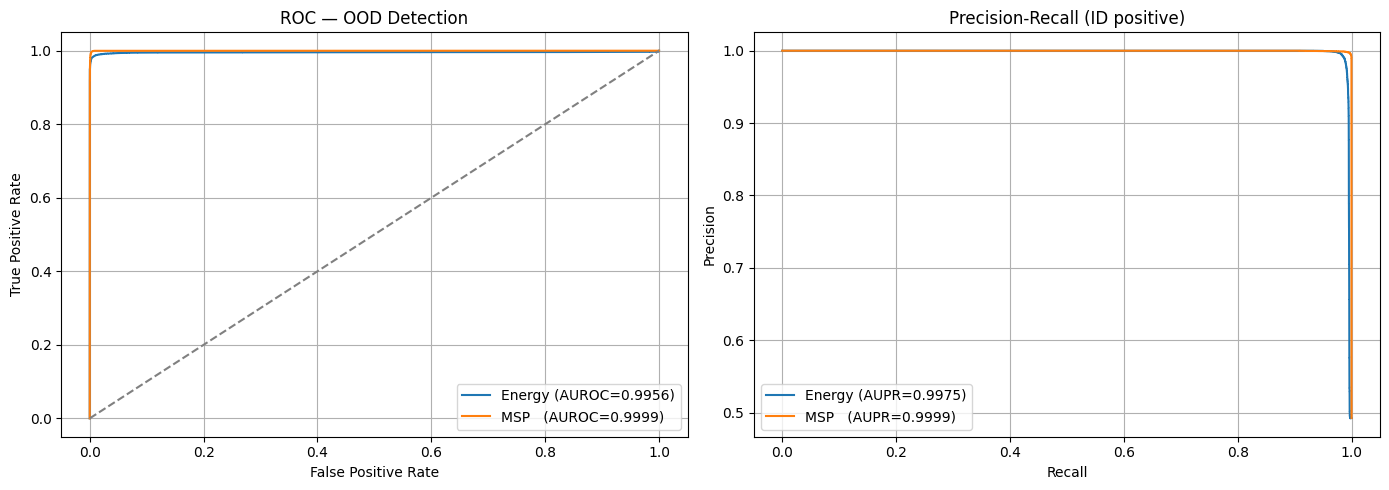

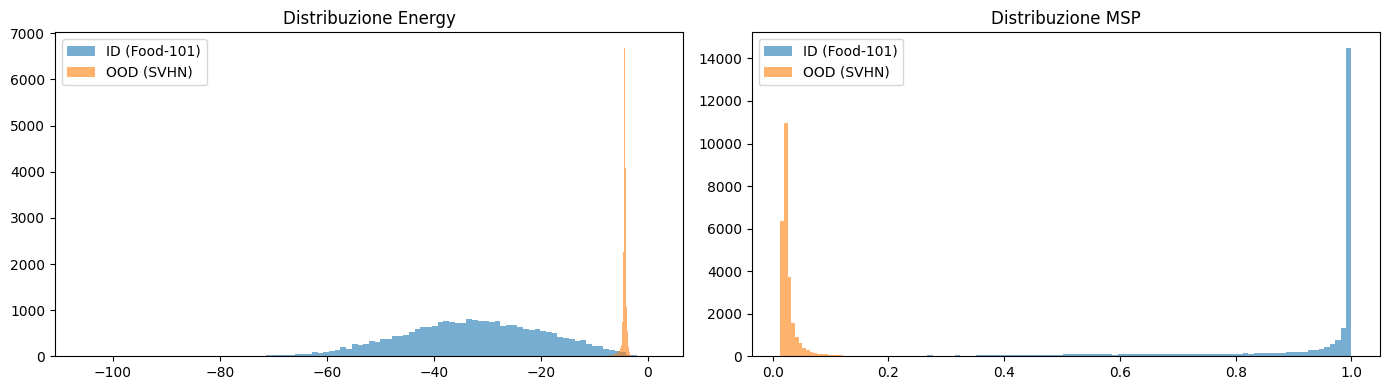

In [12]:
T = 0.35          
PLOT_HIST  = True               

model.eval()

correct = 0
total = 0
with torch.no_grad():
    test_loop = tqdm(test_loader, total=len(test_loader), desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")

# ───────────────────────────────────────────────
# 1. funzioni di scoring
# ───────────────────────────────────────────────
@torch.no_grad()
def get_scores(loader):
    energy, msp = [], []
    for batch in tqdm(loader, desc="Scoring", leave=False):
        x = batch[0] if isinstance(batch, (list, tuple)) else batch
        x = x.to(device, non_blocking=True)

        logits = model(x)
        energy.append((-torch.logsumexp(logits / T, 1)).cpu())          # Energy
        msp.append(torch.softmax(logits, 1).max(1).values.cpu())        # MSP
    return torch.cat(energy).numpy(), torch.cat(msp).numpy()

# ───────────────────────────────────────────────
# 2. ottieni score su ID e OOD
# ───────────────────────────────────────────────
id_energy,  id_msp  = get_scores(test_loader)      # Food-101 (ID)
ood_energy, ood_msp = get_scores(ood_loader)   # SVHN (OOD)

# ───────────────────────────────────────────────
# 3. AUROC / AUPR  
# ───────────────────────────────────────────────
labels = np.concatenate([np.ones_like(id_energy),
                         np.zeros_like(ood_energy)])

auroc_e = roc_auc_score(labels, -np.concatenate([id_energy, ood_energy]))
auroc_m = roc_auc_score(labels,  np.concatenate([id_msp,   ood_msp  ]))

pr_e, rc_e, _ = precision_recall_curve(labels, -np.concatenate([id_energy, ood_energy]))
pr_m, rc_m, _ = precision_recall_curve(labels,  np.concatenate([id_msp,    ood_msp ]))
aupr_e = average_precision_score(labels, -np.concatenate([id_energy, ood_energy]))
aupr_m = average_precision_score(labels,  np.concatenate([id_msp,    ood_msp ]))

# ───────────────────────────────────────────────
# 4. FPR @ 95 TPR 
# ───────────────────────────────────────────────
fpr_e, tpr_e, _ = roc_curve(labels, -np.concatenate([id_energy, ood_energy]))
fpr_m, tpr_m, _ = roc_curve(labels,  np.concatenate([id_msp,   ood_msp  ]))

def fpr_at_tpr(fpr, tpr, target=0.95):
    return np.interp(target, tpr, fpr) if tpr[-1] >= target else 1.0

fpr95_e = fpr_at_tpr(fpr_e, tpr_e)
fpr95_m = fpr_at_tpr(fpr_m, tpr_m)

# ───────────────────────────────────────────────
# 5. stampa
# ───────────────────────────────────────────────
print("\n📊  METRICHE OOD")
print(f"• AUROC  (Energy)      : {auroc_e:.4f}")
print(f"• AUROC  (Soft-max)    : {auroc_m:.4f}")
print(f"• FPR@95TPR (Energy)   : {fpr95_e*100:.2f}%")
print(f"• FPR@95TPR (Soft-max) : {fpr95_m*100:.2f}%")
print(f"• AUPR-In (Energy)     : {aupr_e:.4f}")
print(f"• AUPR-In (Soft-max)   : {aupr_m:.4f}")

# ───────────────────────────────────────────────
# 6. curve ROC / PR
# ───────────────────────────────────────────────
plt.figure(figsize=(14,5))
# ROC
plt.subplot(1,2,1)
plt.plot(fpr_e, tpr_e, label=f"Energy (AUROC={auroc_e:.4f})")
plt.plot(fpr_m, tpr_m, label=f"MSP   (AUROC={auroc_m:.4f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — OOD Detection"); plt.legend(); plt.grid(True)
# PR
plt.subplot(1,2,2)
plt.plot(rc_e, pr_e, label=f"Energy (AUPR={aupr_e:.4f})")
plt.plot(rc_m, pr_m, label=f"MSP   (AUPR={aupr_m:.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall (ID positive)"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────
# 7. istogrammi
# ───────────────────────────────────────────────
if PLOT_HIST:
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].hist(id_energy,  bins=100, alpha=0.6, label="ID (Food-101)")
    ax[0].hist(ood_energy, bins=100, alpha=0.6, label="OOD (SVHN)")
    ax[0].set_title("Distribuzione Energy"); ax[0].legend()

    ax[1].hist(id_msp,  bins=100, alpha=0.6, label="ID (Food-101)")
    ax[1].hist(ood_msp, bins=100, alpha=0.6, label="OOD (SVHN)")
    ax[1].set_title("Distribuzione MSP");  ax[1].legend()
    plt.tight_layout(); plt.show()